In [1]:
# Load a local copy of the current ODYM branch:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from seaborn.palettes import color_palette
import xlrd
import pylab
from copy import deepcopy
import logging as log
from xlrd.biffh import BIFF_FIRST_UNICODE
import xlwt
from scipy.stats import norm
from cycler import cycler
import seaborn as sns
import dynamic_stock_model as dsm

In [2]:
# We load the data for the global vehicle stock and EV penetration form the base IEA scenario
stock = pd.read_excel("/Users/fernaag/Box/BATMAN/Coding/Battery_replacements/data/Global_stock.xlsx", index_col=0)
ev = pd.read_excel("/Users/fernaag/Box/BATMAN/Coding/Battery_replacements/data/motorEnergy_shares.xlsx", index_col=0)

In [3]:
# We calculate the EV stock based on the total stock and penetration
ev_stock = stock.Stock.values * ev["EV penetration"].values

## This model should work for the cases where the battery replacement does not increase the lifetime of the vehicle but can shorten it

In [4]:
model_time = np.arange(2000, 2051, 1)

                There are two survival curves for the model: one related to battery faults and another one related to vehicle failures.
                If the battery fails earlier than the car within warranty, that battery can be replaced by either a used battery from 
                failed vehicles of either the same or older cohorts. If there are not enough batteries to satisfy that need, then new batteries need to 
                be provided by the manufacturer. This batteries will be from the newest technology but of the same capacity as the original battery. 

                If the car fails before the battery and there is no demand for battery replacement, then that battery flows out with the vehicle and 
                is available for either reuse or recycling. If a battery fails before the car without a warranty, then an early outflow of that vehilce is caused. 
                Since some of the vehicles that got a battery replacement will fail, it will cause a supply of relatively new batteries that are available for 
                reuse since they are relatively unused. 

                We need this series of if conditions to be able to track which battery cohorts were used for battery replacements. If there are too many batteries 
                available, then only the newest cohorts should be used.

                We assume that the replacements happpen within the same year.

In [5]:
Nt = 51
# Creating empty dataframes
NewInflows = np.zeros((Nt,Nt)) # Battery replacement comming from new batteries
OldBat_share = np.zeros((Nt,Nt)) # Battery replacement comming from used batteries
Vehicle_outflows = np.zeros((Nt, Nt)) # Battery outflows after battery replacements
Battery_outflows = np.zeros((Nt, Nt)) # Battery outflows after battery replacements
Total_outflows = np.zeros((Nt, Nt)) # Battery outflows after battery replacements

In [6]:
# Replacement parameters
tau                                                                 = 5 # If the vehicles have less than this number left in the fleet, they will not get a replacement battery
warranty                                                            = 10 # This is the number of years coverred by the warranty
reusable                                                            = 5 # This is the maximum age og a battery that will be reused again in the vehicle fleet

In [7]:
# Compute vehicle fleet model
Model                                                     = dsm.DynamicStockModel(t = model_time[:], s = ev_stock[50:], lt = {'Type': 'Normal', 'Mean': np.array([16]), 'StdDev': np.array([4]) })
S_C, O_C, I                                               = Model.compute_stock_driven_model()
O                                                         = Model.compute_outflow_total()
DS                                                        = Model.compute_stock_change()
Vehicle_pdf                                               = Model.compute_outflow_pdf()
# Compute battery model which is fundamentally shaped by the vehice model, i.e. the battery model is driven by the vehicle sales in a first instance
Battery_Model                                             = dsm.DynamicStockModel(t = model_time[:], i = I, lt = {'Type': 'Normal', 'Mean': np.array([9]), 'StdDev': np.array([4]) })
BS_C                                                      = Battery_Model.compute_s_c_inflow_driven()
BO_C                                                      = Battery_Model.compute_o_c_from_s_c()
Battery_pdf                                               = Battery_Model.compute_outflow_pdf()
for t in range(Nt-tau):
    for c in range(Nt-tau):
            if t-c <warranty and t>c and (Model.s_c[t,c] - Battery_Model.s_c[t,c] - O_C[t,c] - O_C[t,c-1] - O_C[t,c-2] - O_C[t,c-3] - O_C[t,c-4] - O_C[t,c-5])>0: ### This applies for vehicles that still have a warranty. FIXME: The knick is because the stock does not continue beyond 2050 --> fix this
                '''
                In this for loop, we compare the stock of batteries  to the stock of vehicles. Since the battery system is driven by the inflow of vehicles and has a shorter lifetime, a gap between the
                two stocks starts to form. This gap needs to be filled by other batteries, as the stock of batteries always needs to be equal to the stock of vehicles. We assume that this gap can be 
                filled by 1) reused batteries from vehicle failures, 2) new batteries. Only those vehicles that are under warranty or that are going to stay in the fleet for at least five years get a 
                replacements (perfect foresight is assumed). Those who are not getting a battery, might either drive with a shitty battery or it may reduce the vehicle's lifetime. In this scenario,
                we assume the latter case. 
                '''
                NewInflows[t,c]                                                 = Model.s_c[t,c] - Battery_Model.s_c[t,c] - O_C[t,c] - O_C[t,c-1] - O_C[t,c-2] - O_C[t,c-3] - O_C[t,c-4] - O_C[t,c-5]
                OldBat_share[t,c]                                               = O_C[t,c]
                OldBat_share[t,c-1]                                             = O_C[t,c-1]
                OldBat_share[t,c-2]                                             = O_C[t,c-2] 
                OldBat_share[t,c-3]                                             = O_C[t,c-3] 
                OldBat_share[t,c-4]                                             = O_C[t,c-4] 
                OldBat_share[t,c-5]                                             = O_C[t,c-5]
                Battery_Model.s_c[t,c]                                          = Battery_Model.s_c[t,c] + NewInflows[t,c]+ OldBat_share[t,c]
            elif t-c <warranty and t>c and (Model.s_c[t,c] - Battery_Model.s_c[t,c] - O_C[t,c] - O_C[t,c-1] - O_C[t,c-2] - O_C[t,c-3] - O_C[t,c-4])>0: 
                NewInflows[t,c]                                                 = Model.s_c[t,c] - Battery_Model.s_c[t,c] - O_C[t,c] - O_C[t,c-1] - O_C[t,c-2] - O_C[t,c-3] - O_C[t,c-4]
                OldBat_share[t,c]                                               = O_C[t,c]
                OldBat_share[t,c-1]                                             = O_C[t,c-1]
                OldBat_share[t,c-2]                                             = O_C[t,c-2] 
                OldBat_share[t,c-3]                                             = O_C[t,c-3] 
                OldBat_share[t,c-4]                                             = O_C[t,c-4] 
                Battery_Model.s_c[t,c]                                          = Battery_Model.s_c[t,c] + NewInflows[t,c]+ OldBat_share[t,c]
            elif t-c <warranty and t>c and (Model.s_c[t,c] - Battery_Model.s_c[t,c] - O_C[t,c] - O_C[t,c-1] - O_C[t,c-2] - O_C[t,c-3])>0: 
                NewInflows[t,c]                                                 = Model.s_c[t,c] - Battery_Model.s_c[t,c] - O_C[t,c] - O_C[t,c-1] - O_C[t,c-2] - O_C[t,c-3] 
                OldBat_share[t,c]                                               = O_C[t,c]
                OldBat_share[t,c-1]                                             = O_C[t,c-1]
                OldBat_share[t,c-2]                                             = O_C[t,c-2] 
                OldBat_share[t,c-3]                                             = O_C[t,c-3] 
                Battery_Model.s_c[t,c]                                          = Battery_Model.s_c[t,c] + NewInflows[t,c]+ OldBat_share[t,c]
            elif t-c <warranty and t>c and (Model.s_c[t,c] - Battery_Model.s_c[t,c] - O_C[t,c] - O_C[t,c-1] - O_C[t,c-2])>0: 
                NewInflows[t,c]                                                 = Model.s_c[t,c] - Battery_Model.s_c[t,c] - O_C[t,c] - O_C[t,c-1] - O_C[t,c-2] 
                OldBat_share[t,c]                                               = O_C[t,c]
                OldBat_share[t,c-1]                                             = O_C[t,c-1]
                OldBat_share[t,c-2]                                             = O_C[t,c-2] 
                Battery_Model.s_c[t,c]                                          = Battery_Model.s_c[t,c] + NewInflows[t,c]+ OldBat_share[t,c]
            elif t-c <warranty and t>c and (Model.s_c[t,c] - Battery_Model.s_c[t,c] - O_C[t,c] - O_C[t,c-1] )>0: 
                NewInflows[t,c]                                                 = Model.s_c[t,c] - Battery_Model.s_c[t,c] - O_C[t,c] - O_C[t,c-1]
                OldBat_share[t,c]                                               = O_C[t,c]
                OldBat_share[t,c-1]                                             = O_C[t,c-1]
                Battery_Model.s_c[t,c]                                          = Battery_Model.s_c[t,c] + NewInflows[t,c]+ OldBat_share[t,c]
            elif t-c <warranty and t>c and (Model.s_c[t,c] - Battery_Model.s_c[t,c] - O_C[t,c] )>0: 
                NewInflows[t,c]                                                 = Model.s_c[t,c] - Battery_Model.s_c[t,c]
                OldBat_share[t,c]                                               = O_C[t,c]
                Battery_Model.s_c[t,c]                                          = Battery_Model.s_c[t,c] + NewInflows[t,c]+ OldBat_share[t,c]
            elif t-c >=warranty and t>c and (Model.s_c[t+tau,c] - Battery_Model.s_c[t,c])>0: 
                '''
                This is the share of batteries that will get replaced by a vehicle owner who's faulty battery is not covered by warranty
                but who plant to keep their vehicle long enough that it will be worth buying a new battery. They will buy a battery of the 
                same vehicle category, but of the newest make. 
                '''
                NewInflows[t,t]                                                 = Model.s_c[t+tau,c] - Battery_Model.s_c[t,c]
                Battery_Model.s_c[t,c]                                          = Battery_Model.s_c[t,c] + NewInflows[t,c]
                '''
                The outflows consist of the vehicle outflows and the battery related outflows. 

                The vehicle related outflows can be just the ones calculated by usign the survival curve, in which case a faulty battery
                does not kill the vehilce. To the contrary, then the vehicle outflows are battery outflows - reused batteries in fleet.

                The battery outflows are the battery related failures plus the vehicle outflows minus the batteries that could be reused
                in the fleet. 
                '''
            Vehicle_outflows[t,c] =  O_C[t,c]
            Battery_outflows[t,c] =  Battery_Model.o_c[t,c] - OldBat_share[t,c] #TODO: Discuss this with Romain

## Plotting results

In [8]:
custom_cycler = cycler(color=sns.color_palette('Set2', 20)) #'Set2', 'Paired', 'YlGnBu'

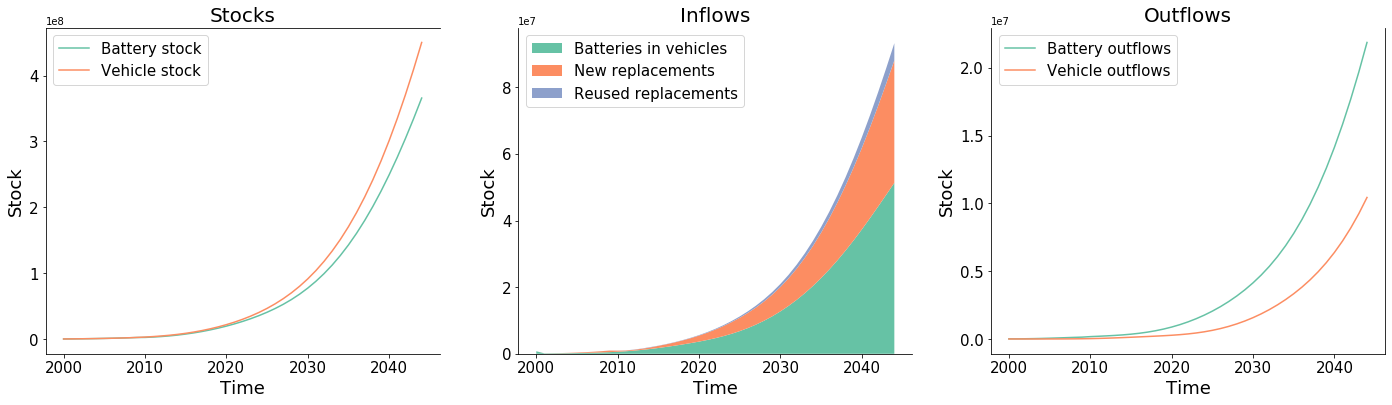

In [9]:
'''
The difference in the stock is the amount of vehicles whose batteries are faulty but were not staying long enough in the fleet to buy a new battery. Here we have two options: either the batteries kill the
vehicles or the vehicles drive with kind of crappy batteries but don't really care because they will get rid of the car soon anyhow. 
'''
fig, ax = plt.subplots(ncols=3, nrows= 1, figsize=(24,6))
ax[0].set_prop_cycle(custom_cycler)
ax[0].plot(model_time[:45], 
           Battery_Model.s_c.sum(axis=1)[:45]) 
ax[0].plot(model_time[:45], 
           Model.s_c.sum(axis=1)[:45]) 
ax[0].set_ylabel('Stock',fontsize =18)
right_side = ax[0].spines["right"]
right_side.set_visible(False)
top = ax[1].spines["top"]
top.set_visible(False)
ax[0].legend(['Battery stock', 'Vehicle stock'], loc='upper left',prop={'size':15})
ax[0].set_title('Stocks', fontsize=20)
ax[0].set_xlabel('Time',fontsize =18)
ax[0].tick_params(axis='both', which='major', labelsize=15)
# Plotting inflows
ax[1].set_prop_cycle(custom_cycler)
ax[1].stackplot(model_time[:45], 
           [I[:45], NewInflows.sum(axis=1)[:45], OldBat_share.sum(axis=1)[:45]]) 
ax[1].set_ylabel('Stock',fontsize =18)
right_side = ax[1].spines["right"]
right_side.set_visible(False)
top = ax[1].spines["top"]
top.set_visible(False)
ax[1].legend(['Batteries in vehicles', 'New replacements', 'Reused replacements'], loc='upper left',prop={'size':15})
ax[1].set_title('Inflows', fontsize=20)
ax[1].set_xlabel('Time',fontsize =18)
ax[1].tick_params(axis='both', which='major', labelsize=15)
# Plotting outflows
ax[2].set_prop_cycle(custom_cycler)
ax[2].plot(model_time[:45], 
           Battery_outflows.sum(axis=1)[:45])
ax[2].plot(model_time[:45], 
           Vehicle_outflows.sum(axis=1)[:45]) 
ax[2].set_ylabel('Stock',fontsize =18)
right_side = ax[1].spines["right"]
right_side.set_visible(False)
top = ax[2].spines["top"]
top.set_visible(False)
ax[2].legend(['Battery outflows', 'Vehicle outflows'], loc='upper left',prop={'size':15})
ax[2].set_title('Outflows', fontsize=20)
ax[2].set_xlabel('Time',fontsize =18)
ax[2].tick_params(axis='both', which='major', labelsize=15)

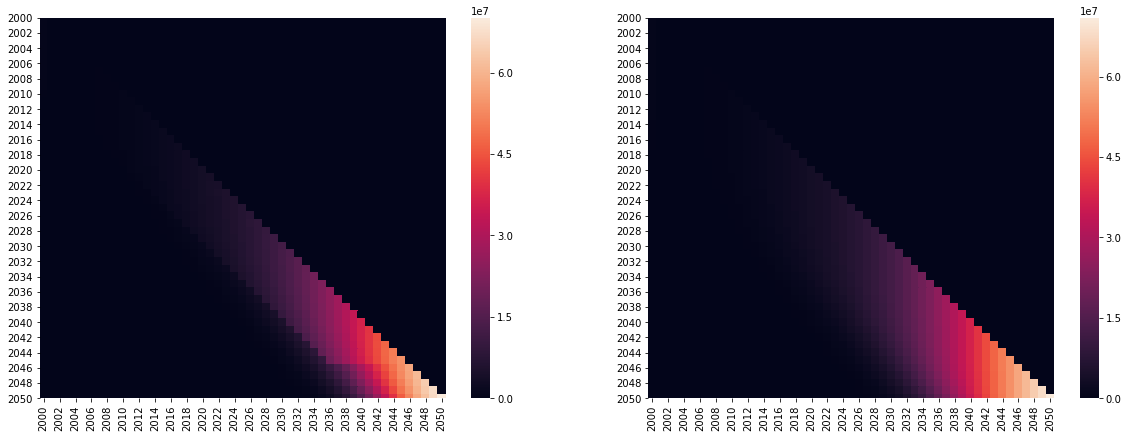

In [10]:
# Creating dataframes to get the right labels
s_tc =pd.DataFrame(Model.s_c).set_index(model_time)
s_tc.columns = model_time
# Battery model
b_s_tc =pd.DataFrame(Battery_Model.s_c).set_index(model_time)
b_s_tc.columns = model_time
'''
We can see here that although the stock is the same, the batteries are overall younger than the vehicles. Depending on the decisions we make for the outflows (lt extensions etc)
we may see different consequences for the reusability of those batteries
'''
fig, ax = plt.subplots(1,2,figsize=(20,7))
sns.heatmap(b_s_tc, ax=ax[0])
sns.heatmap(s_tc, ax=ax[1])